## 2. 다이아몬드 가격 예측

다이아몬드 데이터셋은 약 54,000개 가량의 다이아몬드에 대한 데이터로 다이아몬드의 캐럿, 색깔, 컷과 같은 품질 지표들과 가로, 세로, 높이의 길이, 그리고 달러 기준 가격 정보가 적힌 데이터셋입니다.

회귀나 분류 등 특정 목적을 위해 만들어진 데이터셋이 **아니기** 때문에 목적에 맞게 입력 변수(`X`)와 타겟 변수(`y`)를 설정하면 됩니다.

여기서는 가격을 예측하는 회귀 모델을 실습해보기 위하여 가격(`price`)을 타겟으로 두고 나머지를 입력 변수로 두겠습니다.

---

### 2.1 라이브러리 및 데이터 로드

라이브러리를 로드합니다.

In [40]:
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

데이터를 로드합니다.

In [41]:
data = sns.load_dataset('diamonds')
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


각 컬럼의 의미는 아래와 같습니다.

| 변수명    | 의미  | 값 타입 |
| :------:  | ---- | :-----: |
| `carat`   | 캐럿 | `float` |
| `cut`     | 컷 종류 | `category` |
| `color`   | 색상 | `category` |
| `clarity` | 투명도 | `category` |
| `depth`   | 높이와 너비의 비율 (%) | `float` |
| `table`   | 가장 상단의 길이와 가장 긴 너비의 비율 (%) | `float` |
| `price`   | 가격 (달러) | `int` |
| `x`       | 길이 (mm) | `float` |
| `y`       | 너비 (mm) | `float` |
| `z`       | 높이 (mm) | `float` |

`depth`와 `table`의 의미는 아래 그림을 참고하면 좀더 명확히 이해할 수 있습니다.

<center><img src="https://www.brilliance.com/front/img/what_is_depth_percentage.6aba47a4.png"></center>
<center><img src="https://www.brilliance.com/front/img/diamond_table_percentage_0.05f36c02.jpg"></center>

### 2.2 간단한 EDA

`data`의 dtypes를 확인합니다.

In [42]:
data.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

`data`의 nunique를 확인합니다.

In [43]:
data.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

`data`의 null 갯수를 확인합니다.

In [44]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

`data`의 describe를 확인합니다.

In [45]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


`data`의 상관관계를 확인합니다.

In [46]:
data.corr()  # 숫자형들의 상관관계 확인

C:\Users\king5\AppData\Local\Temp\ipykernel_13280\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


C:\Users\king5\AppData\Local\Temp\ipykernel_13280\2097350719.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr(),


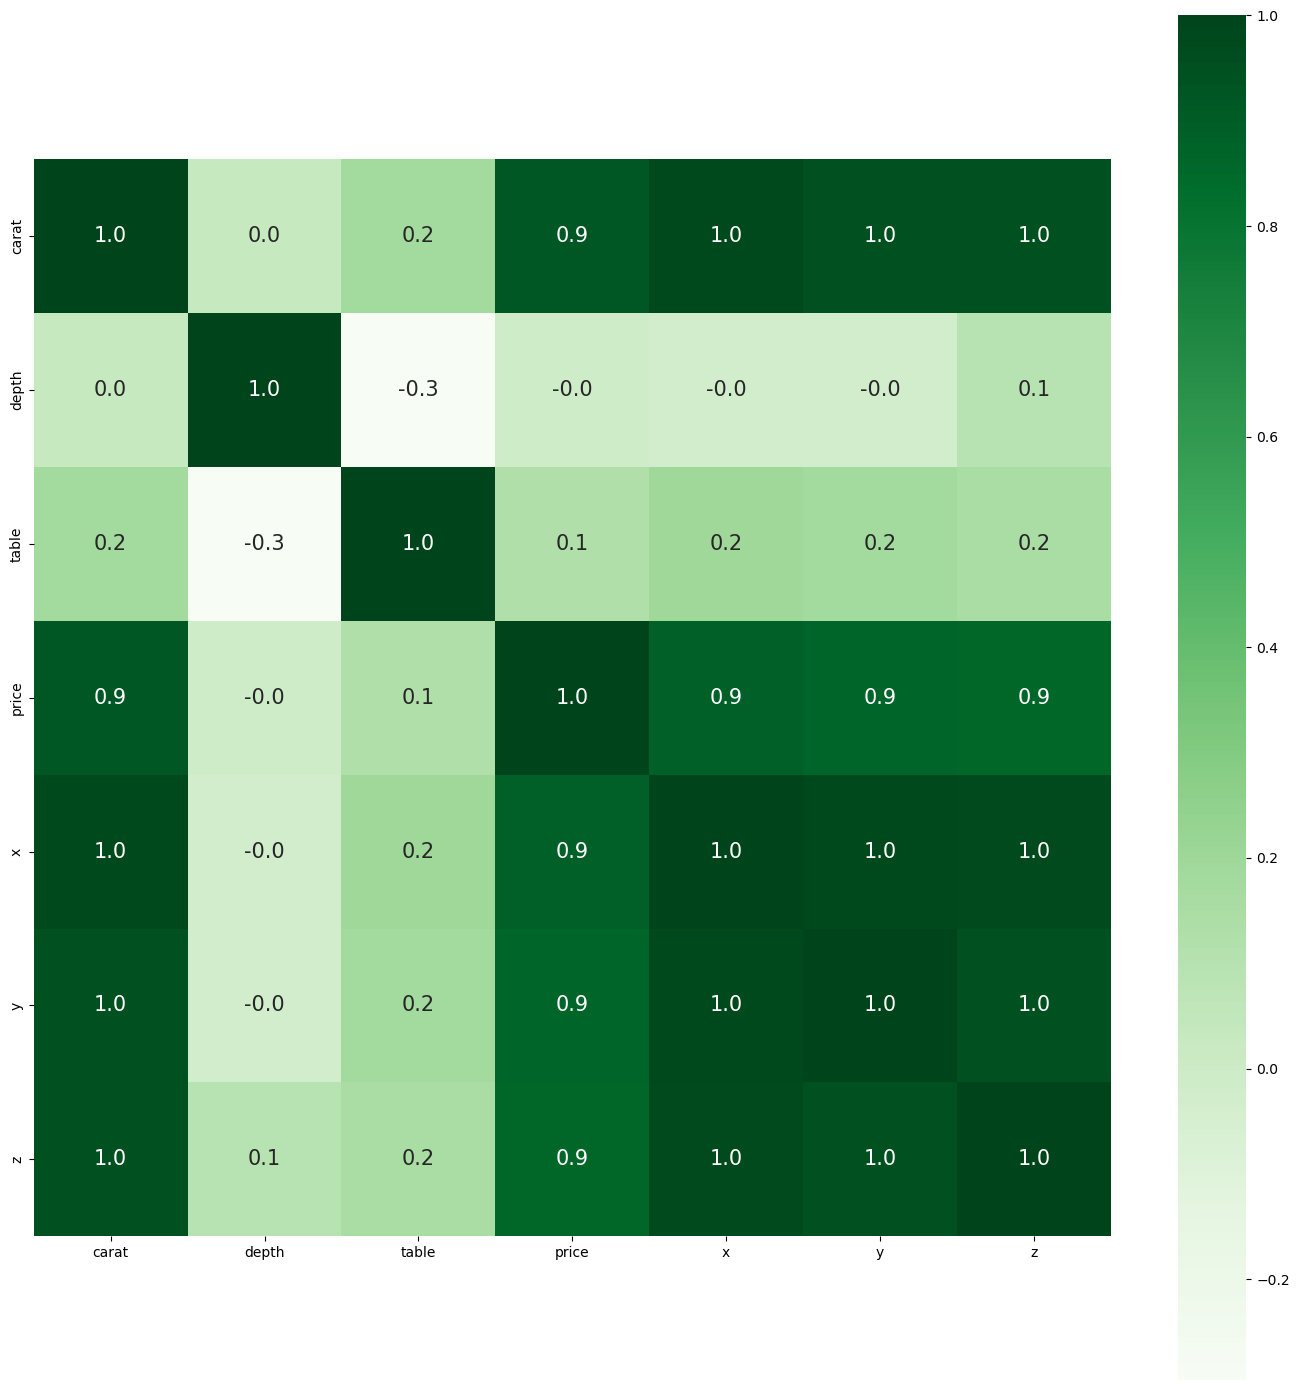

In [47]:
plt.figure(figsize=(14, 14))
sns.heatmap(
    data.corr(),
    cbar=True,
    square=True,
    fmt='.1f',  # 소수점 1의자리 표현
    annot=True,  # 값 표현
    annot_kws={'size': 15},
    cmap='Greens'
)
plt.tight_layout()  # 여백을 최소화하고 딱 맞춰서 출력해줌

### 2.3 데이터 분리

데이터를 분리하기에 앞서 카테고리형 변수는 값이 문자열로 나오므로 정수형으로 바꿔주겠습니다.

In [48]:
category_df = data.select_dtypes(include='category')
category_df

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


In [49]:
encoder = OrdinalEncoder(dtype=np.int64)  # 범주형을 수치형으로 바꿔줌
data[category_df.columns] = encoder.fit_transform(category_df)
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,2,0,2,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,1,0,2,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,4,0,2,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,3,4,3,61.0,58.0,2757,6.15,6.12,3.74


In [51]:
data.dtypes

carat      float64
cut          int64
color        int64
clarity      int64
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

train_test_split을 이용하여 데이터를 분리합니다.

In [54]:
X = data.drop('price', axis=1)
y = data['price'].to_numpy()  # series 형태를 숫자 배열 형태로 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

입력 변수로 사용하는 변수들은 서로 값의 범위가 다릅니다. 이를 같은 범위의 값으로 조정하기 위하여 정규화를 적용하겠습니다.

In [55]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
9077,0.83,4,0,4,58.2,59.0,6.19,6.24,3.62
48769,0.60,2,0,5,60.4,57.0,5.49,5.53,3.33
37238,0.40,3,1,5,62.5,58.0,4.73,4.65,2.93
15565,1.06,2,3,5,61.8,57.0,6.56,6.52,4.04
38295,0.30,2,3,2,60.6,57.0,4.34,4.37,2.63


In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
X_train

array([[ 0.06541419,  1.40548782, -1.52646805, ...,  0.40705406,
         0.44931541,  0.1172248 ],
       [-0.41731787, -0.53833875, -1.52646805, ..., -0.21502679,
        -0.18190146, -0.29849279],
       [-0.83708487,  0.43357454, -0.9375906 , ..., -0.89042885,
        -0.96425476, -0.87189637],
       ...,
       [ 2.54203954,  0.43357454, -0.9375906 , ...,  2.10444608,
         2.04958352,  2.09546713],
       [ 0.21233265,  1.40548782,  0.24016431, ...,  0.48703588,
         0.50265768,  0.23190551],
       [ 0.42221615,  0.43357454, -0.34871315, ...,  0.61145205,
         0.54710957,  0.60461783]])

LGBMRegressor을 `lgbm`으로 선언 후 학습을 진행합니다.

In [58]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

`lgbm`을 이용하여 예측한 값을 `y_pred`에 저장합니다.

In [59]:
y_pred = lgbm.predict(X_test)

`lgbm`의 r2 score, MAE, MSE를 출력합니다.

In [63]:
print(f'R^2: {metrics.r2_score(y_test, y_pred):.6f}')
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.6f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.6f}')

R^2: 0.981477
MAE: 286.735740
MSE: 287236.635749


실제 가격과 예측 가격을 시각화 합니다.

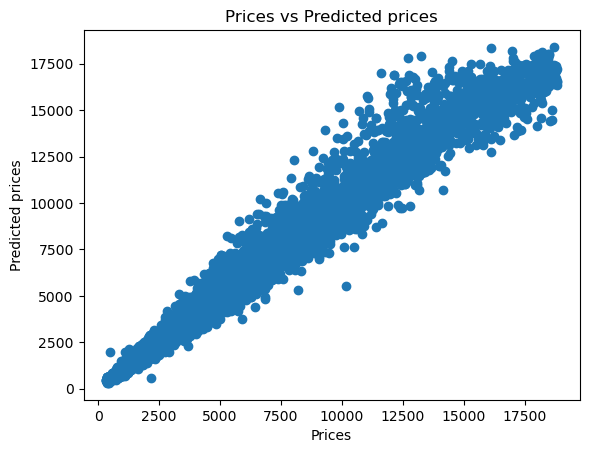

In [64]:
plt.scatter(y_test, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

실제 가격과 예측 가격의 잔차를 시각화 합니다.

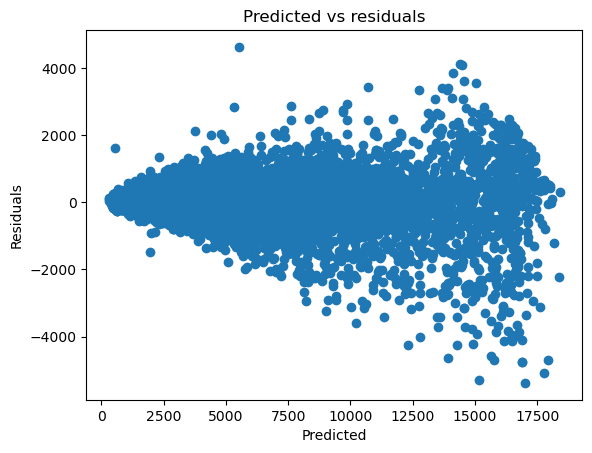

In [65]:
plt.scatter(y_pred, y_test - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

잔차의 정규성을 확인합니다.

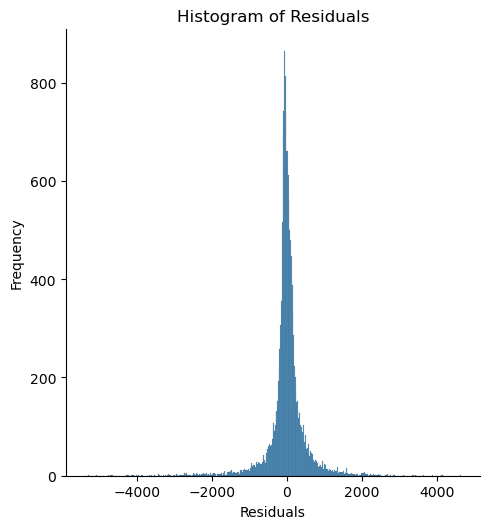

In [66]:
sns.displot(y_test - y_pred)  # displot 차이에 대한 plot
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

**XGBRegressor를 `xgb`로 선언 후 학습을 진행합니다.**

In [67]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**`xgb`를 이용하여 예측한 값을 `y_pred`에 저장합니다.**

In [68]:
y_pred = xgb.predict(X_test)

**`xgb`의 R2 score, MAE, MSE를 출력합니다.**

In [69]:
print('R^2:',metrics.r2_score(y_test, y_pred))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))

R^2: 0.9811199317331615
MAE: 277.00282715318997
MSE: 292768.2083385289


**실제 가격과 예측 가격을 시각화 합니다.**

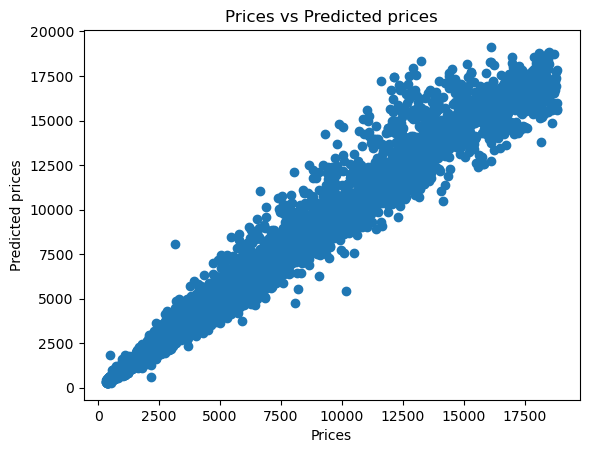

In [70]:
plt.scatter(y_test, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

**실제 가격과 예측 가격의 잔차를 시각화 합니다.**

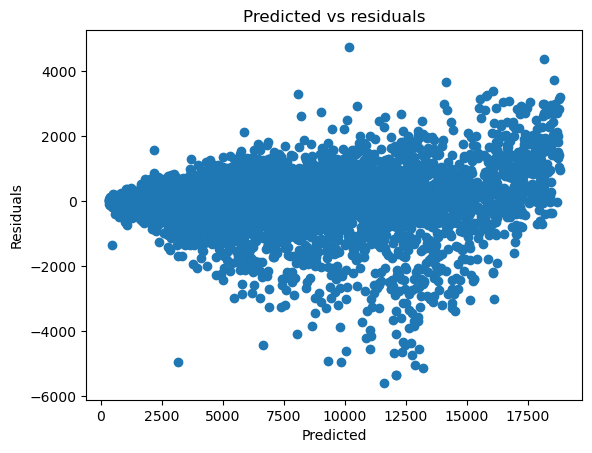

In [71]:
plt.scatter(y_test, y_test - y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

**잔차의 정규성을 확인합니다.**

C:\Users\king5\AppData\Local\Temp\ipykernel_13280\3414167925.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


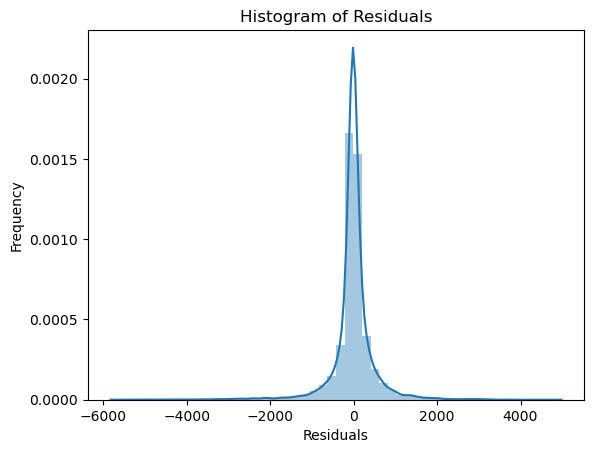

In [72]:
sns.distplot(y_test - y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()